#Data Download

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 9), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (30/30), done.
Face Mask Detection.zip is done!


#Data split

In [2]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


#Dataset 정의

In [3]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            # transform 에 boxes 를 넣어주고 결과물을 다시 target에 저장
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        img = to_tensor(img)


        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

#model

In [4]:
! pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 24 kB/s 
     |████████████████████████████████| 12.7 MB 40.7 MB/s 
     |████████████████████████████████| 7.6 MB 25.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torc

In [5]:
torchvision.__version__

'0.11.1+cu111'

In [6]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_epochs = 30
retina.to(device)

params = [p for p in retina.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
  start = time.time()
  retina.train()

  i = 0    
  epoch_loss = 0

  for images, targets in data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = retina(images, targets) 

    losses = sum(loss for loss in loss_dict.values()) 

    i += 1

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    epoch_loss += losses 
  print(epoch_loss, f'time: {time.time() - start}')

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(280.4929, device='cuda:0', grad_fn=<AddBackward0>) time: 243.21526408195496
tensor(271.5940, device='cuda:0', grad_fn=<AddBackward0>) time: 249.1337547302246
tensor(251.3235, device='cuda:0', grad_fn=<AddBackward0>) time: 250.0908510684967
tensor(237.5118, device='cuda:0', grad_fn=<AddBackward0>) time: 249.22092819213867
tensor(228.0589, device='cuda:0', grad_fn=<AddBackward0>) time: 250.16060733795166
tensor(220.1759, device='cuda:0', grad_fn=<AddBackward0>) time: 250.52933430671692
tensor(204.5988, device='cuda:0', grad_fn=<AddBackward0>) time: 251.5305950641632
tensor(190.3817, device='cuda:0', grad_fn=<AddBackward0>) time: 252.16920399665833
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) time: 232.8304944038391
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) time: 227.79953813552856
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) time: 227.56254863739014
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) time: 227.8472957611084
tensor(nan, device='cuda:0', 

In [8]:
def make_prediction(model, img, threshold):
  model.eval()
  preds = model(img)
  for id in range(len(preds)):
    idx_list = []

    for idx, score in enumerate(preds[id]["scores"]):
      if score > threshold:
        idx_list.append(idx)
    
    preds[id]["boxes"] = preds[id]["boxes"][idx_list]
    preds[id]["labels"] = preds[id]["labels"][idx_list]
    preds[id]["scores"] = preds[id]["scores"][idx_list]

    return preds

In [9]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:23<00:00,  3.68it/s]


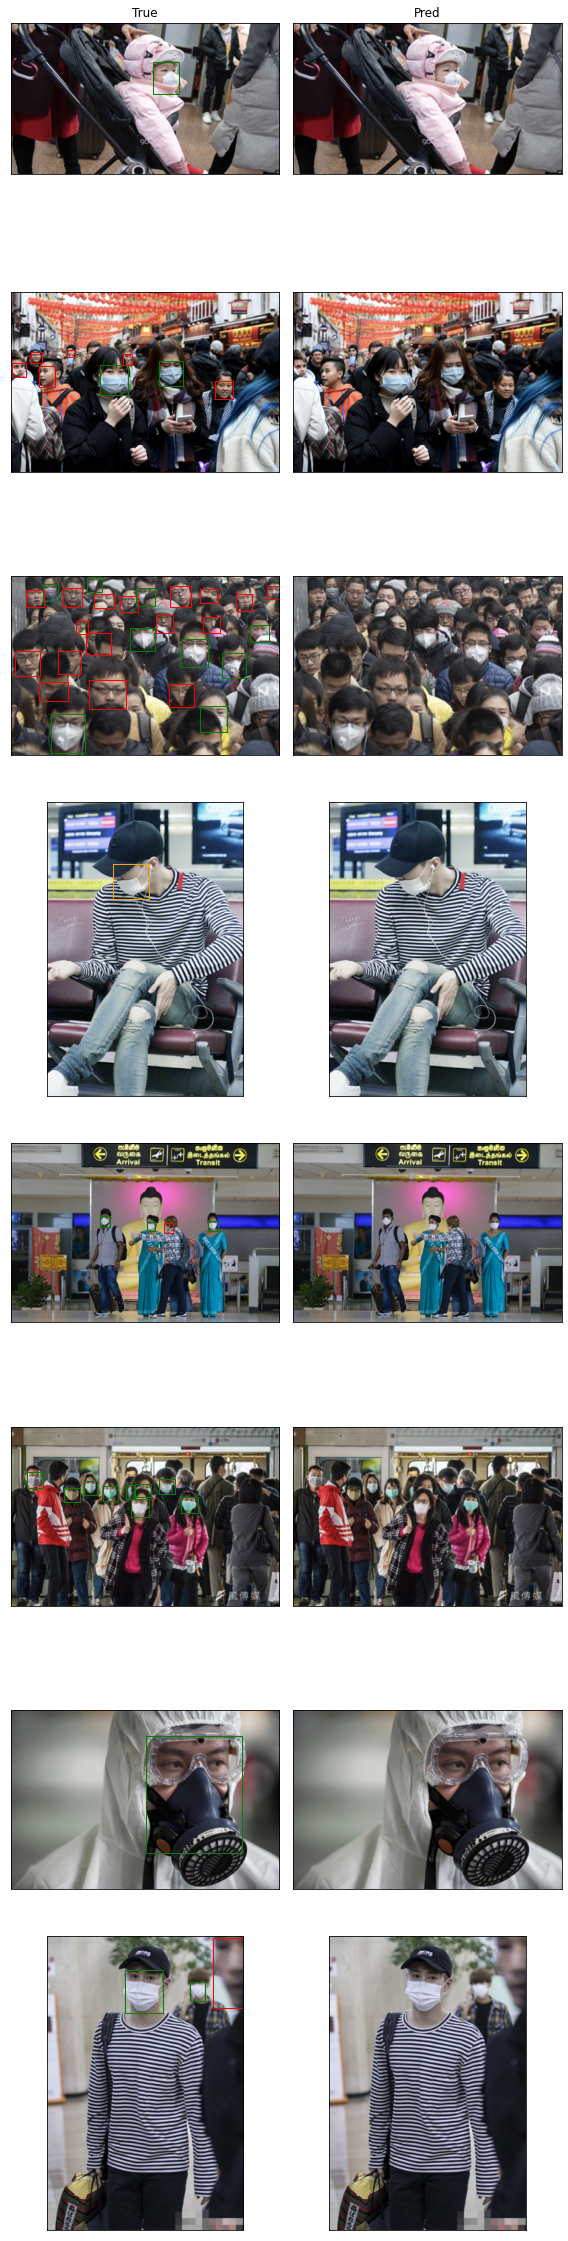

In [10]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()